In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
import scipy

In [3]:
low_b = 2
up_b = 5

In [4]:
x0 = np.linspace(0,up_b)
y0s = np.array([-x0 + b for b in np.linspace(low_b,up_b)])

In [5]:
pairs = pd.DataFrame(np.vstack([np.reshape(y0s,(2500,)),np.tile(x0,int(2500/len(x0)))]).T)
pairs = pairs[pairs[0] >0]

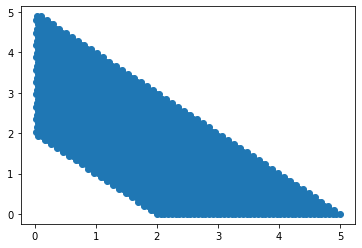

In [6]:
plt.scatter(pairs[0],pairs[1])

In [7]:
pairs_tr = pairs.apply(lambda row: (row[0]*(up_b-low_b)/(row[0]+row[1]) + low_b,row[0]+row[1]),axis=1)
pairs_tr = pd.DataFrame(list(pairs_tr))

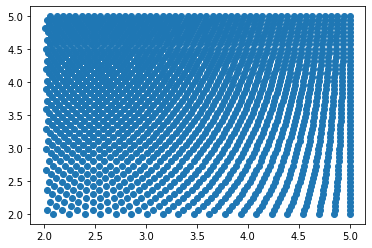

In [8]:
plt.scatter(pairs_tr[0],pairs_tr[1])

# 3d version?

generate coordinates with the rule

$3 \leq \sum x_i \leq 5$

In [9]:
n_points = 1000
points = []
l=3
u=5
while len(points) < n_points:
    candidate = [np.random.random()*5 for i in range(3)]
    if l <= sum(candidate) <= u:
        points.append(candidate)
    else:
        continue

In [10]:
points_tr =\
[
    (
        x[0]*(u-l)/(x[0]+x[1])+l,
        (x[0]+x[1])*(u-l)/(x[0]+x[1]+x[2]) + l,
        x[0]+x[1]+x[2]
    )
    for x in points
]

In [11]:
# yes, the constraints are satisfied
# This is necessary but is it sufficient?
all([all(l<np.array(p)) and all(np.array(p)<=u) for p in points_tr])

True

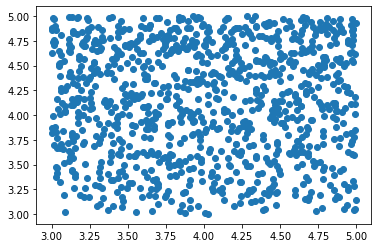

In [12]:
points_tr_df = pd.DataFrame(points_tr)
plt.scatter(x=points_tr_df[0],y=points_tr_df[2])

In [13]:
points_tr[1]

(4.589536177316707, 4.309514474835511, 4.630421576245968)

In [14]:
tr(points[1],l=l,u=u,dim=3)[0]

NameError: name 'tr' is not defined

In [ ]:
points_tr_df[0]

In [ ]:
# does the inverse transformation work?
# it does, but it's quite numerically unstable
def inv_tr(point,l,u):
    dim = len(point)
    cur_index = dim-1
    sums = []
    sums.insert(0,point[cur_index])
    while cur_index > 0:
        last_sum = sums[0]
        next_sum = (last_sum*(point[cur_index-1]-l))/(u-l)
        sums.insert(0,next_sum)
        cur_index = cur_index -1
    x = [sums[i]-sums[i-1] for i in range(dim-1,0,-1)]
    x.reverse()
    x.append(sums[1])
    return np.array(x)

In [ ]:
# maybe we can make it better by posing it as a linear system
# and hoping that the np solver does something smart
from scipy.optimize import root
def inv_tr_lin_solve(point,l,u):
    dim = len(point)
    coeff_matrix = np.eye(dim)
    # add bottom row of ones
    #coeff_matrix[dim-1,:] = np.ones(dim)
    # add coefficients to off-diagonal
    for i in range(0,dim-1):
        coeff_matrix[i,i+1] = (l-point[i])/(u-l)
    #print(coeff_matrix)
    b = np.zeros(dim)
    b[dim-1] = point[dim-1]
    #print(b)
    L = np.tril(np.ones((dim,dim)))
    x = scipy.linalg.solve(coeff_matrix@L,b)
    return x
    #def objective(x):
    #    return (coeff_matrix@L)@x-b
    #return root(objective,np.ones(dim))

In [ ]:
points_un_tr = [inv_tr(point,l,u) for point in points_tr]

In [ ]:
all([all(np.isclose(p1,p2)) for p1,p2 in zip(points_un_tr,points)])

In [ ]:
inv_tr(points_tr[0],l,u)

In [ ]:
sol = inv_tr_lin_solve(points_tr[0],l,u)
print(sol)
sum(sol)

In [ ]:
points[0]

In [ ]:
sol-points[0]

# Stress test: 705 dimensions

In [ ]:
n_points = 1000
points = []
l=3
u=5
while len(points) < n_points:
    candidate = [np.random.random()*5 for i in range(705)]
    if l <= sum(candidate) <= u:
        points.append(candidate)
    else:
        continue

In [ ]:
# better way of generating random numbers?
n_points = 1000
points = []
l=10000
u=12000
while len(points) < n_points:
    target_sum = np.random.random()*(u-l) + l
    x = [np.random.random() for i in range(704)]
    x.insert(0,0)
    x.append(1)
    x.sort()
    points.append(np.diff(x)*target_sum)
    
points = np.float128(points)

In [ ]:
all([l<sum(p)<u for p in points])

In [ ]:
len(points[0])

In [ ]:
#from multiprocess import Pool

In [ ]:
def tr(point,l=10000,u=12000,dim=705):
    point = np.float128(np.array(point))
    point_tr = [((np.sum(point[0:i])*(u-l))/np.sum(point[0:i+1])) + l for i in range(1,dim)]
    point_tr.append(np.sum(point))
    return np.array(point_tr)

In [ ]:
points_tr = np.array([tr(p) for p in points])
len(points_tr[0])

In [ ]:
points_tr[0]

In [ ]:
all([all(l<=p) and all(p <= u) for p in points_tr])

In [ ]:
points_un_tr = [inv_tr_lin_solve(point,l,u) for point in points_tr]

In [ ]:
len(points_un_tr[0])

In [ ]:
len(points[0])

In [ ]:
sum(points_un_tr[0])

In [ ]:
sol = inv_tr_lin_solve(points_tr[0],l,u)
print(sol[0:10])

In [ ]:
points[0][0:10]

In [ ]:
(sol-points[0])*100/points[0][0:10]

In [ ]:
(sol- points[0])*100/points[0]

# Equality constraint
It looks the original inequality constraint is too tricky. Let's try formulating the problem using an equality constraint instead.

## 4 dimensions: basic test

In [16]:
def generate_number_summing_to(sum_target,dim,n_points):
    # better way of generating random numbers?
    points = []
    while len(points) < n_points:
        x = [np.random.random() for i in range(dim)]
        x.insert(0,0)
        x.append(1)
        x.sort()
        points.append(np.diff(x)*sum_target)
    points = np.float128(points)
    return points

In [ ]:
def generate_points_between(l,u,dim,n_points):
    points = []
    while len(points) < n_points:
        x = [np.random.random()*(u-l) + l for i in range(dim)]
        points.append(x)
    points = np.float128(points)
    return points

In [ ]:
points = generate_number_summing_to(160000,4,100)

In [ ]:
points = generate_points_between(10000,12000,4,100)

In [ ]:
# maybe we can make it better by posing it as a linear system
# and hoping that the np solver does something smart
from scipy.optimize import root
def inv_tr_lin_solve_eq(point,l,u,c):
    dim = len(point)
    coeff_matrix = np.eye(dim)
    # add bottom row of ones
    #coeff_matrix[dim-1,:] = np.ones(dim)
    # add coefficients to off-diagonal
    for i in range(0,dim-1):
        coeff_matrix[i,i+1] = (l-point[i])/(u-l)
    #print(coeff_matrix)
    b = np.zeros(dim)
    b[dim-1] = c
    #print(b)
    L = np.tril(np.ones((dim,dim)))
    x = scipy.linalg.solve(coeff_matrix@L,b)
    return x
    #def objective(x):
    #    return (coeff_matrix@L)@x-b
    #return root(objective,np.ones(dim))

In [ ]:
inv_tr_lin_solve_eq(points[0],l=10000,u=12000,c=5)

# new constraint

In [ ]:
v_0 = np.array([0.9,0.91,0.92,0.93])
v_delta = np.random.random(4)
P = np.array([10,20,30,40])
# transform it
v_delta_prime = v_delta*P
v_0_prime = v_0*P
v_delta_tr = np.array([np.sum(v_delta_prime[0:k])/np.sum(v_delta_prime[0:k+1])
         for k in range(1,4)])
v_0_tr = np.array([np.sum(v_0_prime[0:k])/np.sum(v_0_prime[0:k+1])
         for k in range(1,4)])

In [ ]:
print(v_delta_tr)
print(v_0_tr)

In [ ]:
v_delta

# If I sample points confining to my desired constraint, what does it look like in the new space?

In [118]:
dim=3
sum_constr=170
l=0
u=100

upbnd_vec = np.array([60,80,80])

In [119]:
n_points = 10000
points_good = []
points_bad = []
while len(points_good) + len(points_bad) < n_points:
    propose = generate_number_summing_to(sum_constr,dim-1,1)[0]
    if all(propose < upbnd_vec):
        points_good.append(propose)
    else:
        points_bad.append(propose)

In [120]:
def tr(x):
    return np.array([(np.sum(x[0:k])/np.sum(x[0:k+1])*(u-l)+l) for k in range(1,len(x))])
def tr_2(x):
    #return np.array([(np.sum(x[0:k])/np.sum(upbnd_vec[0:k+1])*(u-l)+l) for k in range(1,len(x))])
    x_prime = x/upbnd_vec
    return tr_1(x_prime)

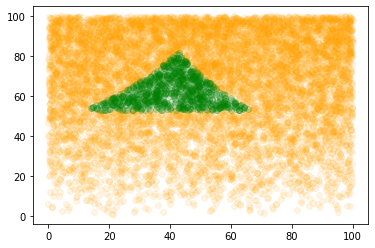

In [121]:
points_tr_good = np.array([tr(x) for x in points_good])
points_tr_bad = np.array([tr(x) for x in points_bad])
plt.scatter(x=points_tr_bad[:,0], y= points_tr_bad[:,1],color="orange",alpha=0.1)
plt.scatter(x=points_tr_good[:,0], y= points_tr_good[:,1],color="green",alpha=0.2)

In [75]:
bad_points = []
n_points = 100
while len(bad_points) < n_points:
    propose = generate_number_summing_to(sum_constr,dim-1,1)[0]
    if all(propose >= upbnd_vec):
        bad_points.append(propose)

KeyboardInterrupt: 

In [72]:
bad_points

[]

## Randomly and uniformly sampling points from the unit simplex

http://www.cs.cmu.edu/~nasmith/papers/smith+tromble.tr04.pdf

In [5]:
import random
def sample_unit_simplex_nonzero(dim):
    M=int(1e16)
    x_n = random.sample(range(0,M),k=dim-1)
    x_n.sort()
    x_n.insert(0,0)
    x_n.append(M)
    diff = np.diff(x_n)
    return diff/M
def sample_unit_simplex_zeros(dim):
    

In [19]:
points = np.array([sample_unit_simplex_nonzero(3) for i in range(10000)])

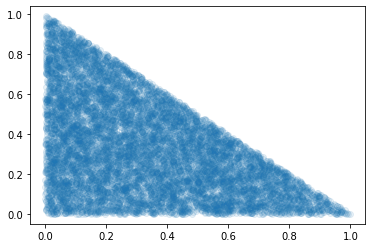

In [23]:
plt.scatter(x=points[:,1], y= points[:,2], alpha=0.1)